In [ ]:
import sys, os
sys.path.append("/home/files/cnsi-sed")

In [43]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.layers as layers
import tensorflow as tf
import numpy as np
import os

#from models.layers import create_conf_head_layers, create_loc_head_layers

In [80]:
block1 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.Conv2D(512, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,6,6,512]

block2 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,3,3,512]
        
block3 = tf.keras.Sequential([tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(512, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,1,1,512]

In [81]:
mobilenet_v2 = MobileNetV2(input_shape=(160,160,3), weights="imagenet", include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


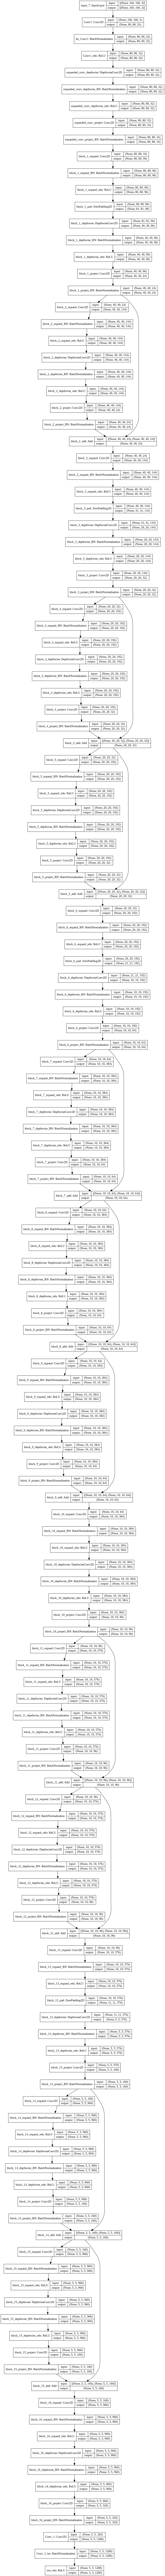

In [82]:
tf.keras.utils.plot_model(mobilenet_v2, show_shapes=True, expand_nested=True)

# Build feature extractor

In [85]:
mobilenet_v2 = MobileNetV2(input_shape=(160,160,3), weights="imagenet", include_top=False)
# feature extractor
fmap10x10 = mobilenet_v2.get_layer("block_13_expand_relu")
feature_extractor = tf.keras.Model(inputs=[mobilenet_v2.input], outputs=[fmap10x10.output])



# Build extra convolutional layers

In [86]:
input_layer = tf.keras.Input(shape=(160,160,3))
x = feature_extractor(input_layer)
y1 = block1(x)
y2 = block2(y1)
y3 = block3(y2)

In [87]:
print(x.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)

(None, 10, 10, 576)
(None, 5, 5, 512)
(None, 3, 3, 512)
(None, 1, 1, 512)


In [88]:
num_classes = 3

In [89]:
#conf header
confs = []
conf = layers.Conv2D(4 * num_classes, kernel_size=3, padding='same')(x)
conf = tf.reshape(conf, [-1, 10*10*4,num_classes])
confs.append(conf)
conf = layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y1)
conf = tf.reshape(conf, [-1, 5*5*6,num_classes])
confs.append(conf)
conf = layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y2)
conf = tf.reshape(conf, [-1, 3*3*6,num_classes])
confs.append(conf)
conf = layers.Conv2D(4 * num_classes, kernel_size=1)(y3)
conf = tf.reshape(conf, [-1, 1*1*4,num_classes])
confs.append(conf)


#location header
locs = []
loc = layers.Conv2D(4 * 4, kernel_size=3, padding='same')(x)
loc = tf.reshape(loc, [-1, 10*10*4,4])
locs.append(loc)
loc = layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y1)
loc = tf.reshape(loc, [-1, 5*5*6,4])
locs.append(loc)
loc = layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y2)
loc = tf.reshape(loc, [-1, 3*3*6,4])
locs.append(loc)
loc = layers.Conv2D(4 * 4, kernel_size=1)(y3)
loc = tf.reshape(loc, [-1, 1*1*4,4])
locs.append(loc)

confs = tf.concat(confs, axis=-2)
locs = tf.concat(locs, axis=-2)

In [90]:
mobilenet_ssd = tf.keras.Model(inputs=[input_layer], outputs=[confs,locs])

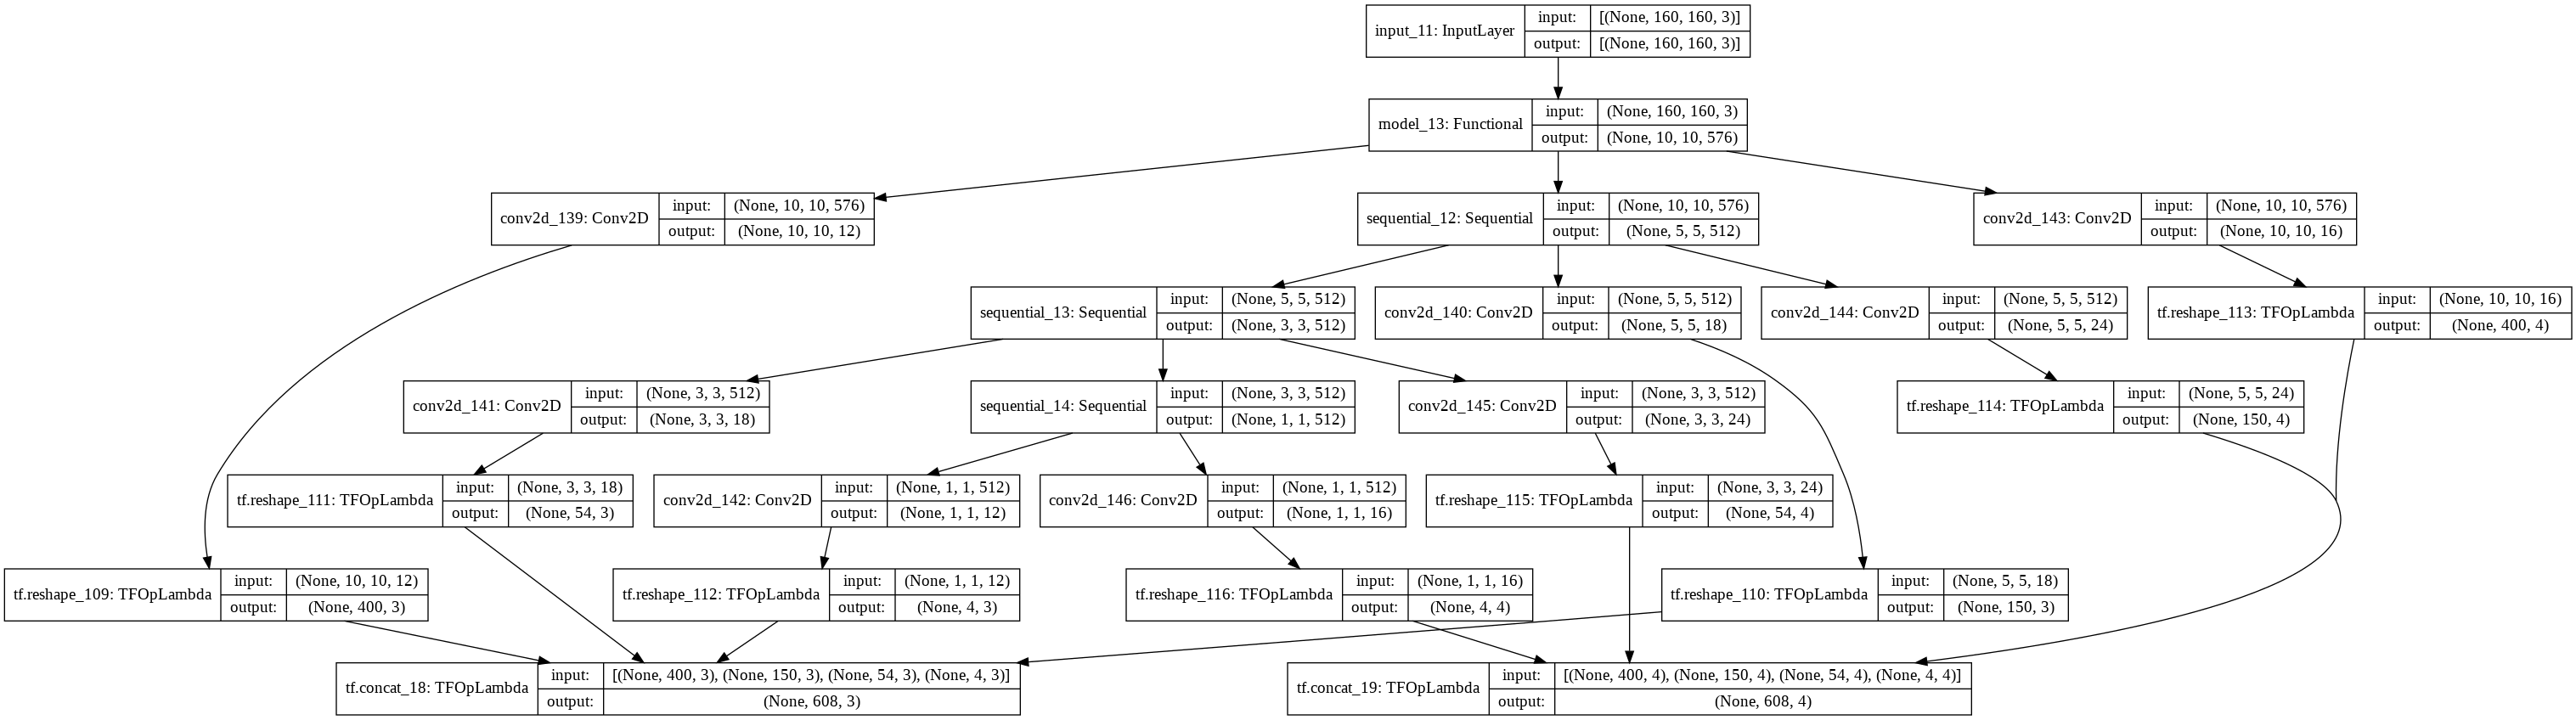

In [91]:
tf.keras.utils.plot_model(mobilenet_ssd, show_shapes=True, expand_nested=False)

In [92]:
mobilenet_ssd.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model_13 (Functional)           (None, 10, 10, 576)  616256      input_11[0][0]                   
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 5, 5, 512)    569344      model_13[0][0]                   
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 3, 3, 512)    536576      sequential_12[1][0]              
___________________________________________________________________________________________

In [93]:
mobilenet_ssd(np.ones([1, 160,160,3]))

[<tf.Tensor: shape=(1, 608, 3), dtype=float32, numpy=
 array([[[ 1.6758615e+00,  4.0896606e-01,  5.9726512e-01],
         [-1.3582149e+00,  9.0998316e-01, -1.3475502e+00],
         [ 1.5598145e+00, -5.7664031e-01, -3.2849264e-01],
         ...,
         [ 1.0147271e-05, -7.9008096e-06, -8.9057806e-07],
         [ 3.3980532e-06,  2.1322953e-06,  1.2600938e-05],
         [-4.7770695e-06, -2.0035291e-06, -2.9616963e-06]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 608, 4), dtype=float32, numpy=
 array([[[-8.7179923e-01,  1.2751482e+00,  6.2148356e-01,  8.7818033e-01],
         [-5.1056713e-01,  1.3227754e+00, -2.3857422e+00,  5.7347512e-01],
         [ 4.7709644e-01,  1.4031431e-01,  6.3730597e-01,  1.2364496e+00],
         ...,
         [ 4.8193638e-06, -7.8671815e-07, -8.4725762e-06,  1.7003052e-06],
         [-3.6657138e-07, -7.5837380e-07,  1.5346347e-07,  6.8560807e-06],
         [-4.9474247e-06,  8.3753312e-06,  2.9326748e-06,  6.5708582e-06]]],
       dtype=float32)>]

In [95]:
mobilenet_ssd.save("ssd160-mobilenet.h5")